In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

api_key = 'DD8C2BE5-C8E6-404E-A289-82A9EBD2D8DC'
symbols = ['COINBASE_SPOT_BTC_USD', 'COINBASE_SPOT_ETH_USD', 'COINBASE_SPOT_XRP_USD']
period_id = '1DAY'
headers = {
    'X-CoinAPI-Key': api_key
}

class CryptoDataPipeline:
    def __init__(self, symbol_id, file_path):
        self.symbol_id = symbol_id
        self.file_path = file_path
        self.data = self.fetch_data()
        self.clean_data()

    def fetch_data(self):
        try:
            url = f'https://rest.coinapi.io/v1/ohlcv/{self.symbol_id}/history?period_id={period_id}'
            response = requests.get(url, headers=headers)

            if response.status_code == 200:
                data = response.json()
                relevant_columns = ['time_period_start', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded']

                # Creating a DataFrame with relevant columns
                df = pd.DataFrame(data)[relevant_columns]

                # Saving to a CSV file
                df.to_csv(self.file_path, index=False)
                print(f"Data for {self.symbol_id} successfully written to {self.file_path}")

                return df
            else:
                print(f"Failed to retrieve data for {self.symbol_id}. Status code: {response.status_code}")
                return pd.DataFrame()

        except Exception as e:
            print(f"An error occurred for {self.symbol_id}: {e}")
            return pd.DataFrame()

    def clean_data(self):
        # Converting time to datetime objects
        self.data['time_period_start'] = pd.to_datetime(self.data['time_period_start'])
        self.data.ffill(inplace=True)
        self.data.bfill(inplace=True)
        numeric_cols = self.data.select_dtypes(include='number').columns
        self.data[numeric_cols] = self.data[numeric_cols].fillna(self.data[numeric_cols].mean())

    def remove_outliers(self):
        price_conditions = (self.data['price_open'] >= 0) & (self.data['price_high'] >= 0) & (self.data['price_low'] >= 0) & (self.data['price_close'] >= 0)
        self.data = self.data[price_conditions]

    def calculate_log_returns(self):
        self.data['time_period_start'] = pd.to_datetime(self.data['time_period_start'])
        self.data.fillna(method='ffill', inplace=True)
        self.data.sort_values(by='time_period_start', inplace=True)
        self.data['log_returns'] = np.log(self.data['price_close'] / self.data['price_close'].shift(1))

    def structure_data(self):
        self.data['daily_price_change'] = self.data['price_close'] - self.data['price_open']

class DataAnalysis(CryptoDataPipeline):
    def __init__(self, symbol_id, file_path, name):
        super().__init__(symbol_id, file_path)
        self.name = name

    def calculateReturns(self):
        return self.data['log_returns']

    def mean(self):
        return self.calculateReturns().mean()

    def median(self):
        return self.calculateReturns().median()

    def STD(self):
        return self.calculateReturns().std()

    def date_with_highest_return(self):
        max_return = self.data.loc[self.calculateReturns().idxmax(), 'time_period_start']
        return max_return

    def previousData(self):
        return self.data['time_period_start'], self.data['price_close']

    def print_analysis(self):
        print(f"{self.name} ANALYSIS:")
        print(f"Mean Return: {self.mean()}")
        print(f"Median Return: {self.median()}")
        print(f"Standard Deviation of Returns: {self.STD()}")
        print(f"Date with Highest Return: {self.date_with_highest_return()}\n")

class DataVisualisation(CryptoDataPipeline):
    def __init__(self, symbol_id, file_path):
        super().__init__(symbol_id, file_path)

    def plotHistoricalPrices(self):
        plt.figure(figsize=(12, 8))
        
        time_periods, closing_prices = self.previousData()
        
        plt.plot(time_periods, closing_prices, label=self.symbol_id, linewidth=2, color='red')

        plt.title("Historical Prices of Cryptocurrency", fontsize=16)
        
        plt.xlabel("Time Period", fontsize=14)
        plt.ylabel("Closing Price", fontsize=14)
        
        plt.legend(fontsize=12)
        
        plt.show()

    def plotMean(self, crypto_analysis):
        cryptocurrencies = [analysis.name for analysis in crypto_analysis]
        mean_returns = [analysis.mean() for analysis in crypto_analysis]

        plt.figure(figsize=(10, 6))
        
        plt.bar(cryptocurrencies, mean_returns, color=['red', 'blue', 'green'])
        
        plt.title("Mean Returns Comparison", fontsize=16)
        plt.xlabel("Cryptocurrency", fontsize=14)
        plt.ylabel("Mean Return", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        plt.show()

    def compare_prices_line_chart(self, obj):
        plt.figure(figsize=(12, 8))

        for analysis in obj:
            time_periods, closing_prices = analysis.previousData()
            plt.plot(time_periods, closing_prices, label=analysis.name)

        plt.title("Comparison of Historical Prices", fontsize=16)
        plt.xlabel("Time Period", fontsize=14)
        plt.ylabel("Closing Price", fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

    def previousData(self):
        return self.data['time_period_start'], self.data['price_close']

# Create objects for each cryptocurrency
btc_obj = DataAnalysis('COINBASE_SPOT_BTC_USD', 'COINBASE_SPOT_BTC_USD_data.csv', 'BTC')
eth_obj = DataAnalysis('COINBASE_SPOT_ETH_USD', 'COINBASE_SPOT_ETH_USD_data.csv', 'ETH')
xrp_obj = DataAnalysis('COINBASE_SPOT_XRP_USD', 'COINBASE_SPOT_XRP_USD_data.csv', 'XRP')

btc_obj.calculate_log_returns()
eth_obj.calculate_log_returns()
xrp_obj.calculate_log_returns()

# Analysis for each cryptocurrency
btc_obj.print_analysis()
eth_obj.print_analysis()
xrp_obj.print_analysis()

# Printing correlation matrix
correlation_matrix = pd.DataFrame({
    'BTC': btc_obj.calculateReturns(),
    'ETH': eth_obj.calculateReturns(),
    'XRP': xrp_obj.calculateReturns()
})

print("Correlation Matrix:")
print(correlation_matrix.corr())




Data for COINBASE_SPOT_BTC_USD successfully written to COINBASE_SPOT_BTC_USD_data.csv
Data for COINBASE_SPOT_ETH_USD successfully written to COINBASE_SPOT_ETH_USD_data.csv
Data for COINBASE_SPOT_XRP_USD successfully written to COINBASE_SPOT_XRP_USD_data.csv
BTC ANALYSIS:
Mean Return: 0.002748375997003551
Median Return: 0.001460080949863414
Standard Deviation of Returns: 0.0334387631297854
Date with Highest Return: 2024-03-20 00:00:00+00:00

ETH ANALYSIS:
Mean Return: 0.0029953061441626524
Median Return: 0.004459396566999323
Standard Deviation of Returns: 0.03819840042888249
Date with Highest Return: 2024-05-20 00:00:00+00:00

XRP ANALYSIS:
Mean Return: -9.232251267117384e-05
Median Return: 0.0
Standard Deviation of Returns: 0.038780734924118855
Date with Highest Return: 2024-03-11 00:00:00+00:00

Correlation Matrix:
          BTC       ETH       XRP
BTC  1.000000  0.834547  0.618601
ETH  0.834547  1.000000  0.646665
XRP  0.618601  0.646665  1.000000


C:\Users\Hp\AppData\Local\Temp\ipykernel_9264\2839754449.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data.fillna(method='ffill', inplace=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_9264\2839754449.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data.fillna(method='ffill', inplace=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_9264\2839754449.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data.fillna(method='ffill', inplace=True)


Data for COINBASE_SPOT_BTC_USD successfully written to COINBASE_SPOT_BTC_USD_data.csv
Data for COINBASE_SPOT_ETH_USD successfully written to COINBASE_SPOT_ETH_USD_data.csv
Data for COINBASE_SPOT_XRP_USD successfully written to COINBASE_SPOT_XRP_USD_data.csv


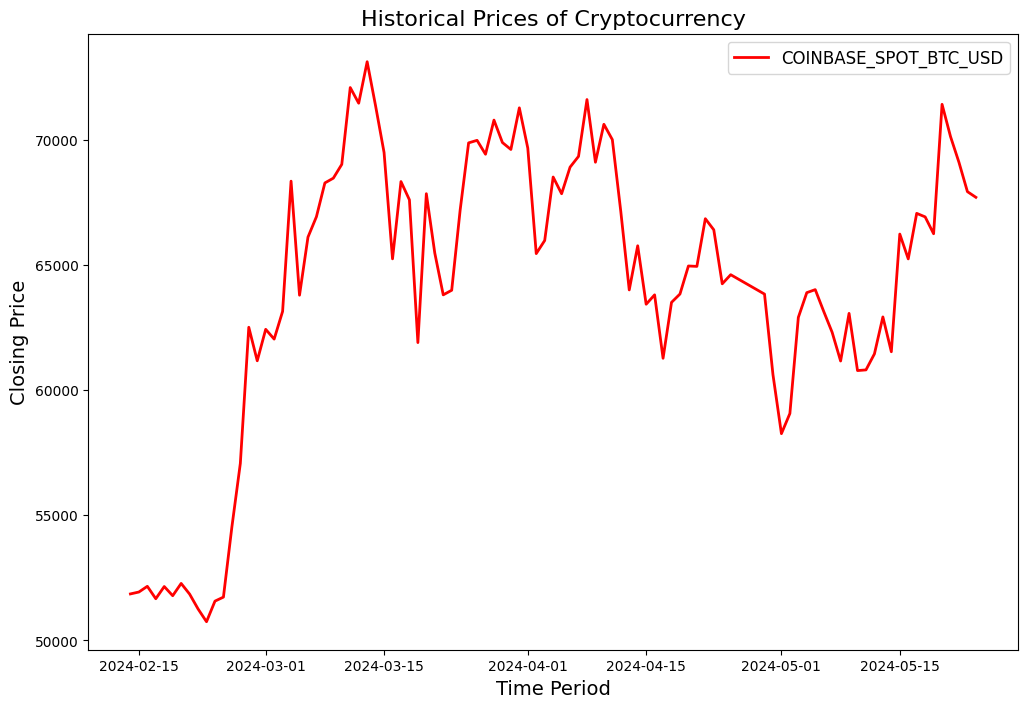

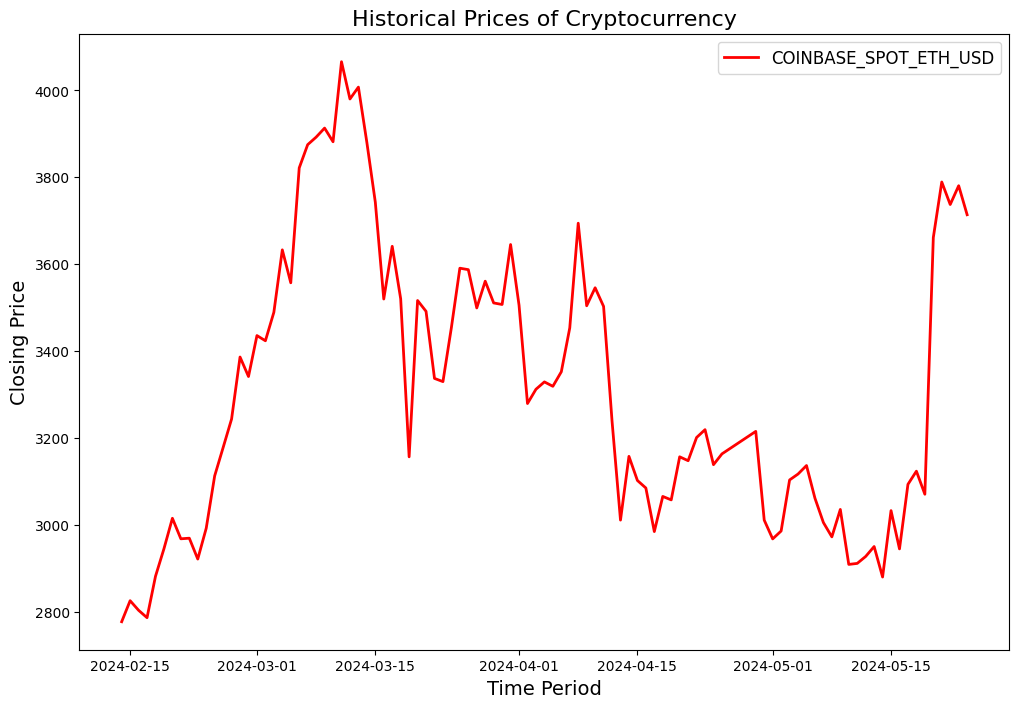

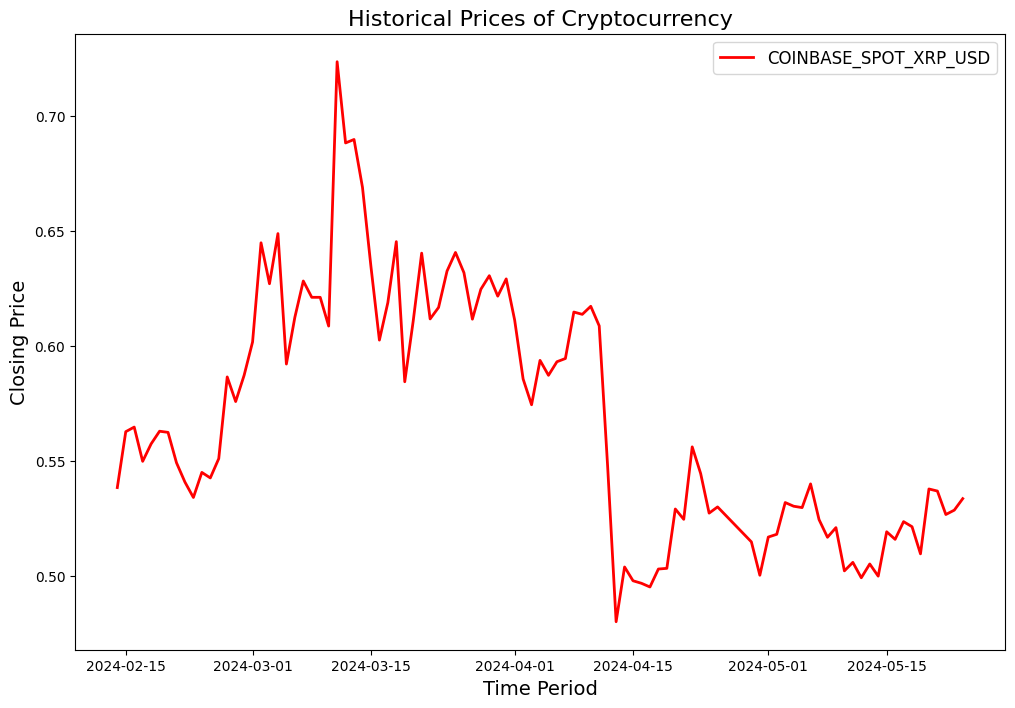

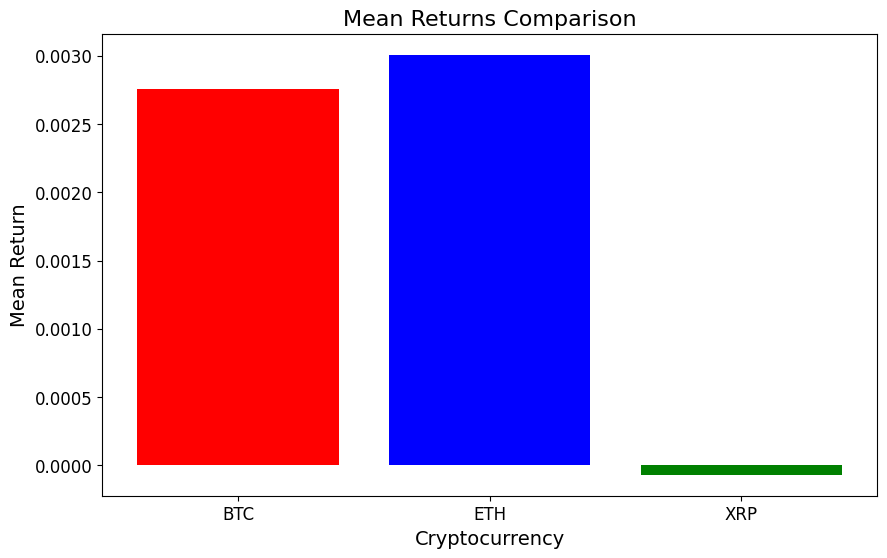

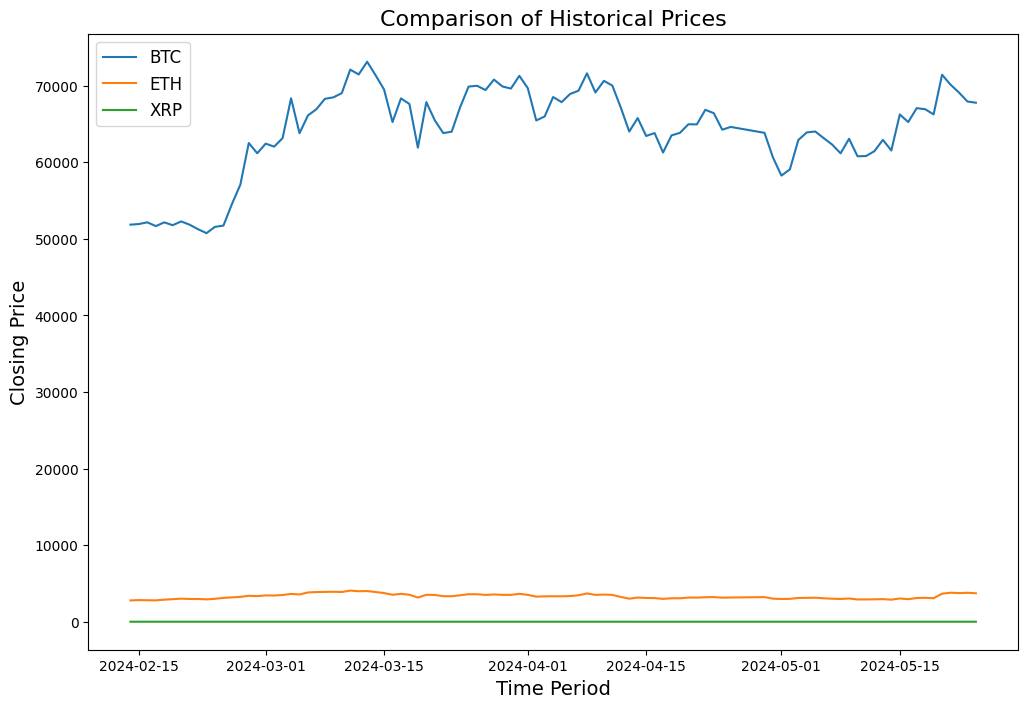

In [3]:
# Creating objects for visualization
btc_visual = DataVisualisation('COINBASE_SPOT_BTC_USD', 'COINBASE_SPOT_BTC_USD_data.csv')
eth_visual = DataVisualisation('COINBASE_SPOT_ETH_USD', 'COINBASE_SPOT_ETH_USD_data.csv')
xrp_visual = DataVisualisation('COINBASE_SPOT_XRP_USD', 'COINBASE_SPOT_XRP_USD_data.csv')

crypto_obj = [btc_obj, eth_obj, xrp_obj]

# Visualize historical prices
btc_visual.plotHistoricalPrices()
eth_visual.plotHistoricalPrices()
xrp_visual.plotHistoricalPrices()

# Mean returns using bar chart
btc_visual.plotMean(crypto_obj)
btc_visual.compare_prices_line_chart(crypto_obj)